# Laboratorio: Classificazione (parte 2)

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
nome.cognome@unibo.it

In [1]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy

## Riepilogo: Classificazione con iperpiani

- In un problema di _classificazione_ dobbiamo suddividere correttamente delle osservazioni in _classi_ predefinite
  - a differenza della regressione in cui dobbiamo predire un valore in un dominio continuo
- I casi più comuni prevedono la classificazione _binaria_, ovvero con due possibili classi
- I modelli lineari funzionano tramite l'individuazione di un _iperpiano_ nello spazio delle variabili che separi quanto meglio possibile le osservazioni tra le due classi

- Riprendiamo il [set di dati sulle cellule tumorali](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) utilizzato nella prima parte

In [2]:
BCWDS_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
bcwds = pd.read_csv(BCWDS_URL, header=None, index_col=0)

- Assegniamo i nomi alle colonne come fatto l'altra volta

In [3]:
cell_features = ["radius",     "texture",
                 "perimeter",  "area",
                 "smoothness", "compactness",
                 "concavity",  "concave_pts",
                 "symmetry",   "fractal_dim"]
stats = ["mean", "std", "worst"]
bcwds.columns = ["diagnosis"] + [s + "_" + f for s in stats for f in cell_features]

In [4]:
bcwds.head(5)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_pts,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_pts,worst_symmetry,worst_fractal_dim
0,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


- Impostiamo come variabile da predire la classe `diagnosis` ("B" o "M") e come variabili predittive tutte le altre 30

In [5]:
y = bcwds["diagnosis"]
X = bcwds.drop(columns="diagnosis")

- Suddividiamo i dati in training e validation set con proporzione 66-33

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/3, random_state=42)

## Esercizio 1: Addestramento e validazione modelli

- Definiamo un modello di regressione logistica configurandone l'implementazione e il seed per la casualità
  - gli altri parametri sono lasciati ai valori di default, ad es. la regolarizzazione applicata è L2 con C=1

In [7]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(solver="saga", random_state=42)

- **(1a)** Addestrare il modello sul training set e calcolarne l'accuratezza sul validation set
- **(1b)** Ripetere gli stessi passaggi su un modello `model2` con la stessa configurazione di `model1`, ma applicando la standardizzazione alle variabili

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
model1.fit(X_train, y_train)
model1.score(X_val, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9578947368421052

In [11]:
model2 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(penalty="l1", solver="saga", random_state=42))
])
model2.fit(X_train, y_train)
model2.score(X_val, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9842105263157894

## Classificazione a più classi

- I modelli di classificazione basati su un iperpiano presuppongono che i dati siano suddivisi in esattamente due classi
- Come costruire un modello che classifichi dei dati in più di due classi?
- Si possono combinare **molteplici modelli** basati su iperpiano, ciascuno riferito ad una specifica classe

- Per visualizzare il funzionamento di un modello multiclasse, serviamoci del classico dataset d'esempio "Iris"
  - ogni osservazione corrisponde ad un fiore
  - le variabili predittive sono la lunghezza e larghezza di petali e sepali
  - la classe da prevedere è la specie del fiore, tra 3 possibili
- Questo dataset è incluso nel modulo `datasets` di scikit-learn

In [12]:
from sklearn.datasets import load_iris
iris_data = load_iris()

- Otteniamo un frame `iris_X` con le variabili predittive...

In [13]:
iris_X = pd.DataFrame(iris_data["data"], columns=iris_data["feature_names"])
iris_X.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


- ...e una serie `iris_y` con le corrispondenti classi (specie dei fiori), di cui vediamo la distribuzione

In [14]:
iris_y = pd.Series(iris_data["target_names"][iris_data["target"]])
iris_y.value_counts()

virginica     50
setosa        50
versicolor    50
dtype: int64

- Consideriamo le prime due variabili, _sepal length_ e _sepal width_

In [15]:
iris_Xsep = iris_X.iloc[:, [0, 1]]

- Definiamo un dizionario con i colori da associare alle classi

In [16]:
iris_color_map = {"setosa": "blue", "versicolor": "green", "virginica": "red"}

- Visualizziamo uno scatter plot delle due variabili, con punti colorati in base alla classe

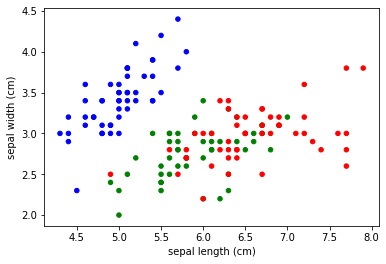

In [17]:
iris_Xsep.plot.scatter(iris_Xsep.columns[0], iris_Xsep.columns[1],
                       c=iris_y.map(iris_color_map));

- Per addestrare un modello di regressione logistica, creiamo normalmente un oggetto `LogisticRegression`
- Tale oggetto incapsulerà **un iperpiano per distinguere ciascuna classe**
- Tali iperpiani possono essere estratti in due modi
  - con `multi_class="ovr"` (_one versus rest_) per ciascuna classe C si addestra un modello indipendentemente dagli altri a distinguere "C" da "non C"
  - con `multi_class="multinomial"` (default) viene calcolata e minimizzata un'unica funzione d'errore (con eventuale regolarizzazione) su tutti gli iperpiani
- Usiamo ad esempio in modo esplicito la modalità default "ovr"

In [18]:
model = LogisticRegression(C=10, multi_class="ovr",
                           solver="saga",random_state=42)

- Addestriamo il modello come al solito col metodo `fit`
  - avendo poche osservazioni ed essendo solo un esempio illustrativo, non suddividiamo i dati in training e validation set

In [19]:
model.fit(iris_Xsep, iris_y);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


- Negli attributi `coef_` e `intercept_` del modello troviamo questa volta i coefficienti di 3 iperpiani invece che di uno

In [20]:
model.coef_

array([[-4.1447591 ,  6.60324145],
       [ 0.44157874, -2.18028243],
       [ 1.63875599, -1.80890275]])

In [21]:
model.intercept_

array([ 1.75073607,  3.17637618, -5.09021097])

- Riprendiamo dalla scorsa esercitazione la funzione `separator_2d` per graficare un iperpiano di un modello con 2 variabili, modificata in modo che possiamo scegliere l'iperpiano da graficare (parametro `n`)

In [22]:
def separator_2d(model, x1, n=0):
    return -x1*model.coef_[n, 0]/model.coef_[n, 1] -model.intercept_[n]/model.coef_[n, 1]

- Creiamo un grafico con tutti e 3 gli iperpiani (rette nel caso a 2 variabili) sovrapposti ai dati

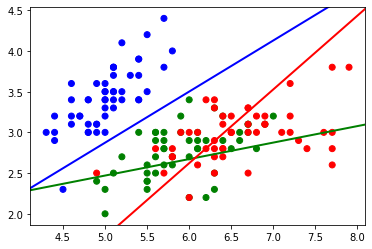

In [23]:
plt.scatter(*iris_Xsep.values.T, c=iris_y.map(iris_color_map))
xlim, ylim = plt.xlim(), plt.ylim()
for n, c in enumerate(model.classes_):
    sep_x = np.linspace(*xlim, 2)
    sep_y = separator_2d(model, sep_x, n)
    plt.plot(sep_x, sep_y, c=iris_color_map[c], linewidth=2)
plt.xlim(xlim); plt.ylim(ylim);

- In ogni punto del piano abbiamo una distribuzione di proabilità tra le 3 classi, influenzata dai 3 iperpiani

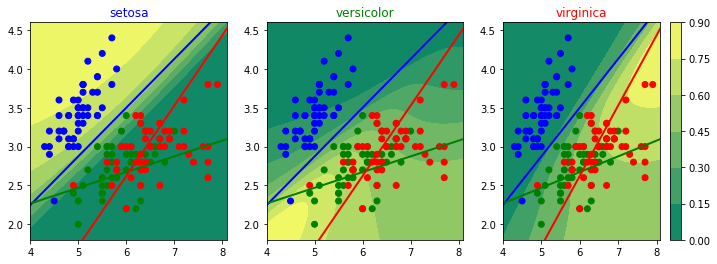

In [24]:
mx1, mx2 = np.meshgrid(np.linspace(4, 8.1, 100), np.linspace(1.8, 4.6, 100))
plt.figure(figsize=(12, 4))
for pn, pc in enumerate(model.classes_):
    ax = plt.subplot(1, 3, pn+1)
    my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, pn].reshape(mx1.shape)
    contplot = ax.contourf(mx1, mx2, my, cmap="summer")
    ax.scatter(*iris_Xsep.values.T, c=pd.Series(iris_y).map(iris_color_map))
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    sep_x = np.linspace(*xlim, 2)
    for rn, rc in enumerate(model.classes_):
        sep_y = separator_2d(model, sep_x, rn)
        ax.plot(sep_x, sep_y, c=iris_color_map[rc], linewidth=2)
    ax.set_title(model.classes_[pn], c=iris_color_map[pc])
    ax.set_xlim(xlim); ax.set_ylim(ylim)
plt.colorbar(contplot);

- Dalla distribuzione otteniamo la classe più probabile in ciascun punto
- Otteniamo in pratica 3 regioni di spazio, ciascuna costituita dall'intersezione di 2 semispazi

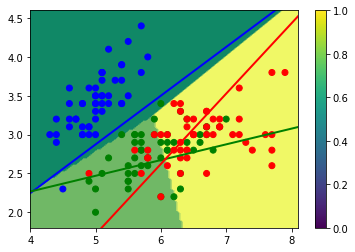

In [25]:
mx1, mx2 = np.meshgrid(np.linspace(4, 8.1, 100), np.linspace(1.8, 4.6, 100))
my = model.predict(np.c_[mx1.ravel(), mx2.ravel()])
my = np.array([list(model.classes_).index(c) for c in my])
my = my.reshape(mx1.shape)
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*iris_Xsep.values.T, c=pd.Series(iris_y).map(iris_color_map))
plt.colorbar();
xlim, ylim = plt.xlim(), plt.ylim()
for n, c in enumerate(model.classes_):
    sep_x = np.linspace(*xlim, 2)
    sep_y = separator_2d(model, sep_x, n)
    plt.plot(sep_x, sep_y, c=iris_color_map[c], linewidth=2)
plt.xlim(xlim); plt.ylim(ylim);

- Valutiamo l'accuratezza del modello

In [26]:
model.score(iris_Xsep, iris_y)

0.8

- Per avere maggiori informazioni, estraiamo la matrice di confusione

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(iris_y, model.predict(iris_Xsep))
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,setosa,versicolor,virginica
setosa,49,1,0
versicolor,2,29,19
virginica,0,8,42


- Come si nota anche graficamente, la maggior parte degli errori è tra le classi _versicolor_ (verde) e _virginica_ (rossa)

## Caso di studio: Marketing mirato

- Per aumentare il rendimento delle campagne di marketing, un'azienda deve selezionare accuratamente i clienti target di ciascuna
- Per prendere decisioni consapevoli, si possono sfruttare le informazioni sulle campagne precedenti
- Il dataset [Predicting Profitable Customer Segments](https://www.kaggle.com/tsiaras/predicting-profitable-customer-segments) da Kaggle fornisce dati ricavati da campagne pubblicitarie di un'azienda di vendite online
- Usare il comando sotto per caricare il dataset
  - il file all'URL dato è un archivio ZIP, lo specifichiamo nella funzione `read_csv` per far sì che pandas estragga il file CSV dal suo interno

In [28]:
ctds = pd.read_csv("https://git.io/JfEXh", compression="zip")

- Vediamo alcune delle colonne presenti come esempio

In [29]:
ctds.iloc[:5, [0, 1, 2, 21, 22, 23, 42, 43, 44, 70]]

,g1_1,g1_2,g1_3,g2_1,g2_2,g2_3,c_1,c_2,c_3,target
0,4.50,1,3,1.83,6,0,1.97,-1,7,2
1,2.20,24,22,2.80,34,14,1.85,2,1,1
2,12.00,7,4,1.30,11,18,1.70,-5,10,2
3,1.91,8,5,4.50,5,3,1.98,-1,3,0
4,2.50,23,16,3.00,29,23,1.80,-3,2,2


- Ad ogni riga corrisponde un confronto tra due diversi gruppi di clienti su cui si è svolta una stessa campagna di marketing
- Le colonne `g1_*` e `g2_*` indicano diverse caratteristiche dei due gruppi presi singolarmente
- Le colonne `c_*` sono invece derivate dal confronto tra i due gruppi
  - nella documentazione del dataset non sono dati i significati specifici di ciascuna colonna

- La colonna `target` indica su quale dei due gruppi la campagna ha dato maggiori profitti
  - 0 = nessuno dei due gruppi ha dato profitti degni di nota
  - 1 = il primo gruppo ha datto maggiori profitti
  - 2 = il secondo gruppo ha dato maggiori profitti

In [30]:
ctds["target"].value_counts()

1    3076
2    1877
0    1667
Name: target, dtype: int64

- L'obiettivo è estrarre un modello di classificazione che, date le variabili estratte dalle caratteristiche dei due gruppi e dal relativo confronto, preveda se uno dei due dia più profitti e quale
- Definiamo quindi come `y` la variabile `target` e come `X` tutte le altre

In [31]:
X = ctds.drop(columns="target")
y = ctds["target"]

## Esercizio 2: Classificazione a più classi

- **(2a)** Suddividere casualmente i dati `X, y` in un training set col 75\% dei dati e in un test set col restante 25\%
- **(2b)** Eseguire una grid search sul training set con cross validation a 3 fold stratificati casuali per individuare il modello di regressione logistica con parametri migliori secondo le seguenti specifiche:
  - standardizzazione delle variabili
  - regolarizzazione `l2` oppure `l1`
  - costo `C` variabile tra 0.01, 0.1, 1, 10
  - modalità `multi_class` pari a `ovr` o `multinomial`
- **(2c)** Estrarre l'accuratezza sul test set del modello ottenuto sopra
- **(2d)** Estrarre la matrice di confusione
- **(2e)** Estrarre lo score F1 su ciascuna classe

In [32]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

In [34]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1/4)

In [35]:
skf = StratifiedKFold(3, shuffle=True)
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="saga"))
])
grid = {
    "logreg__penalty": ["l2", "l1"],
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__multi_class": ["ovr", "multinomial"]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Convergence

In [36]:
gs.score(X_test, y_test)

0.5903323262839879

In [37]:
cm = confusion_matrix(y_test, gs.predict(X_test))
pd.DataFrame(cm, index=gs.classes_, columns=gs.classes_)

,0,1,2
0,7,284,122
1,7,676,79
2,8,178,294


In [38]:
f1_score(y_test, gs.predict(X_test), average=None)

array([0.03218391, 0.71157895, 0.60307692])

## Classificazione non lineare

- Abbiamo visto finora come addestrare classificatori lineari, che separano lo spazio delle variabili in regioni convesse
- Possiamo avere a che fare però con set di dati con classi non linearmente separabili, per cui tali classificatori non possono funzionare in modo soddisfacente
- Vediamo un esempio di funzionamento con un dataset sintetico generato casualmente
- La funzione `make_circles` genera punti in un piano distribuiti in due corone circolari concentriche

- Generiamo due dataset da una stessa distribuzione, uno per training e l'altro per validazione

In [39]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5, random_state=42)

- Ciascuna istanza è un punto sul piano, la cui classe è 0 (cerchio esterno) o 1 (cerchio interno)

In [40]:
X_train[:5]

array([[ 0.4677266 ,  0.05443974],
       [-0.34703554, -0.30774354],
       [-0.915094  ,  0.46046701],
       [ 0.48564263,  0.22661689],
       [ 0.6280253 , -0.08921573]])

In [41]:
y_train[:5]

array([1, 1, 0, 1, 1])

- Visualizziamo i punti del training set, colorati in base alla loro classe reale

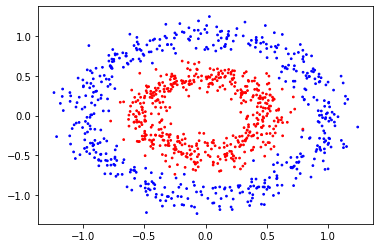

In [42]:
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

- Vogliamo addestrare un classificatore a distinguere, date le coordinate di un punto, se faccia parte del cerchio esterno o di quello interno

## Esercizio 3: Modello lineare

- **(5a)** Addestrare un modello di regressione logistica sui dati di training
- **(5b)** Calcolare l'accuratezza del modello sul validation set
- **(5c)** Creare un grafico a dispersione del validation set con i punti colorati in base alla classe predetta dal modello

In [44]:
model = LogisticRegression(solver="saga")
model.fit(X_train, y_train);

In [45]:
model.score(X_val, y_val)

0.497

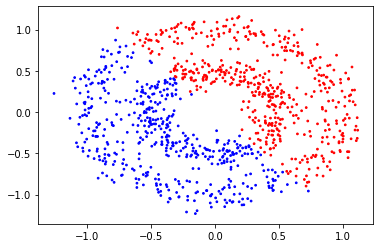

In [46]:
y_pred = model.predict(X_val)
plt.scatter(*X_val.T, s=3, c=np.where(y_pred, "red", "blue"));

- Essendo un classificatore lineare, non è in grado di separare correttamente le due classi
- Per maggiore dettaglio, creiamo una funzione per visualizzare le regioni di spazio in cui il classificatore suddivide i dati

In [47]:
def plot_class_model(X, y, model):
    plt.scatter(X[:, 0], X[:, 1])
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    try:
        # se son disponibili le probabilità, crea uno sfondo sfumato in base ad esse
        mz = model.predict_proba(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    except AttributeError:
        # altrimenti mostra la separazione netta tra le due classi
        mz = model.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

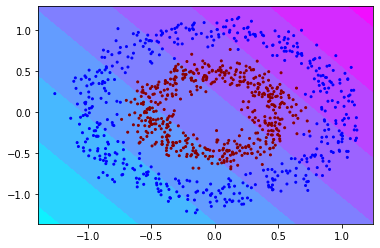

In [48]:
plot_class_model(X_val, y_val, model)

- Le sfumature sullo sfondo indicano le probabilità con cui il classificatore assegna un punto ad una classe o all'altra

- Conoscendo la forma del dataset, possiamo introdurre nuove variabili specifiche tali per cui le classi diventino linearmente separabili
- Introduciamo ad esempio variabili polinomiali di secondo grado

In [49]:
from sklearn.preprocessing import PolynomialFeatures
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr",   LogisticRegression(solver="saga"))
])
model.fit(X_train, y_train);

In [50]:
model.score(X_val, y_val)

0.993

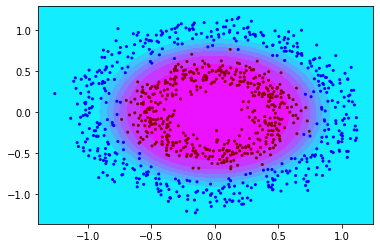

In [51]:
plot_class_model(X_val, y_val, model)

- Grazie all'uso dei quadrati delle variabili come feature, è possibile separare linearmente le due classi

- A conferma, si vedano i coefficienti del modello di regressione: i due con valori più significativi sono quelli dei quadrati (`x0^2` e `x1^2`)

In [52]:
pd.Series(
    model.named_steps["lr"].coef_[0],
    index=model.named_steps["poly"].get_feature_names()
)

x0       0.007462
x1      -0.075480
x0^2    -8.344887
x0 x1   -0.053286
x1^2    -8.368229
dtype: float64

- Si veda inoltre il grafico a dispersione dove invece delle variabili `x0` e `x1` rappresentiamo i rispettivi quadrati

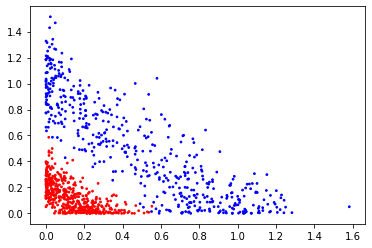

In [53]:
plt.scatter(*(X_val**2).T, s=3, c=np.where(y_val, "red", "blue"));

- Con questa rappresentazione le due classi sono linearmente separabili
- Tale rappresentazione è però stata decisa arbitrariamente da noi
- Come ottenere un modello accurato senza generare manualmente delle feature?

## Support Vector Machines

- Il metodo delle Support Vector Machines (SVM) è stato formulato in origine per la classificazione binaria
- Consiste nell'individuare un iperpiano di separazione ottimale tra le due classi basandosi sulle istanze più vicine ad esso, i cosiddetti _support vector_
- Come nella regressione kernel ridge vista in precedenza, possono essere utilizzate delle funzioni kernel per effettuare una classificazione non lineare

- La classe `SVC` rappresenta un modello di classificazione SVM
- Per addestrare un semplice modello con un kernel lineare, specifichiamo `kernel="linear"`

In [54]:
from sklearn.svm import SVC
model = SVC(kernel="linear")

- Come consueto, addestriamo il modello con `fit` e calcoliamone l'accuratezza con `score`

In [55]:
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.533

- Essendo la classificazione lineare, non è possibile separare le due classi
  - di default SVC non calcola le probabilità delle classi: è possibile specificare `probability=True` nel costruttore per abilitarla aumentando però i tempi di calcolo

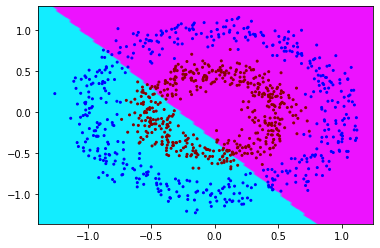

In [56]:
plot_class_model(X_val, y_val, model)

- Addestriamo ora un modello che utilizza una funzione kernel polinomiale
- Come in `KernelRidge`, specifichiamo `kernel="poly"` e indichiamo il grado del kernel con `degree`, ad esempio 2
  - `gamma` è un coefficiente moltiplicativo usato nel kernel, specificando `scale` è impostato in automatico

In [57]:
model = SVC(kernel="poly", degree=2, gamma="scale")
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.993

- Grazie alla funzione kernel, il classificatore SVM è efficace

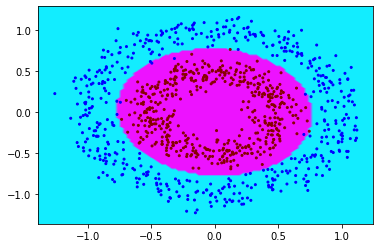

In [58]:
plot_class_model(X_val, y_val, model)

- Gli indici dei support vector individuati nell'addestramento sono salvati in un attributo `support_`
  - i support vector effettivi sono accessibili in `support_vectors_`

In [59]:
len(model.support_)

70

- Possiamo creare una funzione `plot_support_vectors` per visualizzare i vettori di supporto, mettendoli in evidenza rispetto al resto dei dati d'addestramento

In [60]:
def plot_support_vectors(X, y, model):
    Xs = X[model.support_]
    ys = y[model.support_]
    plt.scatter(X[:, 0], X[:, 1], s=4, c=np.where(y, "#ffbbbb", "#bbbbff"))
    plt.scatter(Xs[:, 0], Xs[:, 1], s=8, c=np.where(ys, "#dd0000", "#0000dd"))

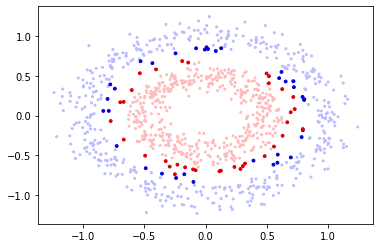

In [61]:
plot_support_vectors(X_train, y_train, model)

- I vettori evidenziati sono quelli più vicini alla linea che separa le due classi

- Possiamo testare altri kernel, ad esempio RBF (radial basis function), adatto in un caso come questo dove le istanze di una classe sono concentrate intorno ad un punto

In [62]:
model = SVC(kernel="rbf", gamma="scale")
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.995

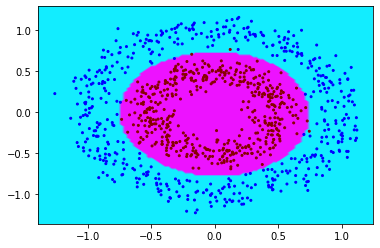

In [63]:
plot_class_model(X_val, y_val, model)

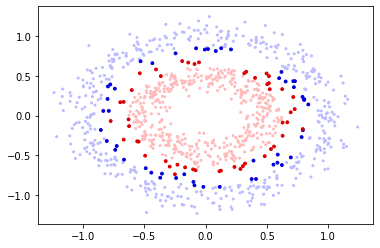

In [64]:
plot_support_vectors(X_train, y_train, model)

- In `SVC` è inoltre possibile impostare il parametro `C`, che influenza la penalità data alle classificazioni errate
  - il valore di default di `C` è 1
  - come in `LogisticRegression`, valori di `C` alti rendono più preciso il modello sui dati di addestramento ma possono causare overfitting
- Ad esempio, in un caso ideale come questo dove con istanze quasi perfettamente separabili (usando appropriate funzioni kernel), abbassando `C` l'accuratezza peggiora

In [65]:
model = SVC(kernel="poly", degree=2, gamma="scale", C=0.001)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.851

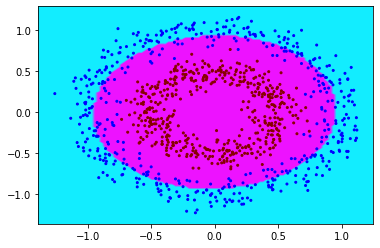

In [66]:
plot_class_model(X_val, y_val, model)

## Multi-layer perceptron

- L'output di un classificatore lineare $y$ è un iperpiano determinato dalla combinazione lineare delle variabili $x_1,\ldots,x_n$ in input, ciascuna con un peso diverso
  - quì indichiamo il bias o intercetta come "peso" $w_0$
$$ w_0+w_1\cdot x_1+\ldots+w_n\cdot x_n = 0 $$
- Poniamo di introdurre delle variabili _nascoste_ (_hidden_) $h_1,\ldots,h_m$ in modo che
  - l'iperpiano individuato dal modello sia combinazione lineare delle variabili nascoste
$$ w_0+w_1\cdot h_1+\ldots+w_m\cdot h_m = 0 $$
  - ciascuna variabile nascosta sia combinazione lineare di quelle in ingresso
$$ h_i = v_{i,0}+v_{i,1}\cdot x_1+\ldots+v_{i,n}\cdot x_n $$
- Questo tipo di modello viene definito _multi-layer perceptron_, in quanto si tratta in pratica di più modelli lineari disposti a strati

- Per creare un modello di classificazione di questo tipo usiamo la classe `MLPClassifier`
  - con `hidden_layer_sizes` specifichiamo il numero di variabili nascoste da introdurre, ad esempio 4
  - con `activation="identity"` specifichiamo che tali variabili sono lineari

In [67]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=4, activation="identity")

- Eseguiamo ora l'addestramento del modello
  - viene utilizzata la discesa gradiente _stocastica_: ciascun aggiustamento dei pesi è basato su un campione casuale di osservazioni di training
  - l'errore e la relativa derivata sono calcolati per l'output finale e a cascata per ciascuna delle variabili nascoste (_backpropagation_)

In [68]:
model.fit(X_train, y_train);

- Negli attributi `coefs_` e `intercepts_` del modello addestrato troviamo liste di array con pesi e bias suddivisi per strato
  - allo strato 0 troviamo 2×4 pesi e 4 bias con cui dalle 2 variabili di input sono calcolate le 4 nascoste
  - allo strato 1 troviamo 4 pesi e 1 bias con cui dalle 4 variabili intermedie è calcolato l'output finale

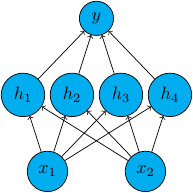

In [69]:
model.coefs_

[array([[-0.38861698, -0.3875768 , -0.29864856, -0.41816608],
        [-0.24139122,  0.41320331,  0.16059642,  0.21677786]]),
 array([[-0.28220811],
        [-0.630303  ],
        [-0.41403314],
        [ 0.86105169]])]

In [70]:
model.intercepts_

[array([-0.02271375, -0.24677114,  0.31427256,  0.73585755]),
 array([-0.6620956])]

- Vediamo come prima il grafico con le probabilità delle classi indicate dal modello

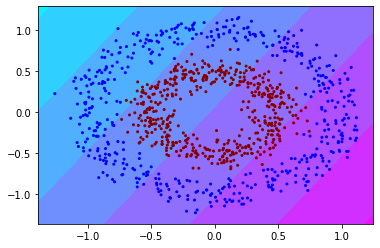

In [71]:
plot_class_model(X_val, y_val, model)

- Il grafico risulta identico a quello dei modelli lineari semplici
- Anche l'accuratezza rimane la stessa

In [72]:
model.score(X_val, y_val)

0.497

- Questo è dovuto al fatto che, anche con più strati, l'output finale **rimane una combinazione lineare dell'input**
- Possiamo aggiungere espressività al modello introducendo **trasformazioni non lineari**

- La funzione _ReLU_ (_rectified linear unit_) è un esempio di funzione che introduce non linearità
$$ \text{ReLU}(x) = \max(0, x) $$
- Definiamola in Python, usando la funzione `maximum` di NumPy per ottenerne una versione vettoriale (applicabile ad un array di valori)

In [73]:
def relu(x):
    return np.maximum(0, x)

- Possiamo usarla ad es. per tracciarne il grafico

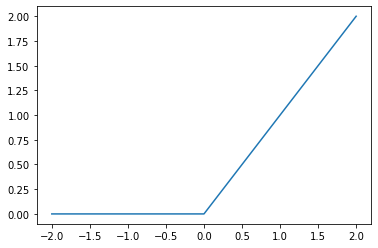

In [74]:
px = np.linspace(-2, 2, 101)
py = relu(px)
plt.plot(px, py);

- Essendo una funzione **continua e derivabile**, rimane utilizzabile nel modello addestrato con la discesa gradiente (stocastica)

- Riconfiguriamo il modello in modo tale che il valore delle variabili nascoste sia il risultato dell'applicazione di ReLU alla combinazione lineare degli input
$$ h_i = \text{ReLU}(v_{i,0}+v_{i,1}\cdot x_1+\ldots+v_{i,n}\cdot x_n) $$
- Per far ciò, specifichiamo `activation="relu"` (default) nella configurazione di `MLPClassifier`
- Addestriamo un modello con 2 sole variabili nascoste per poter visualizzarle in seguito

In [75]:
model = MLPClassifier(hidden_layer_sizes=2, activation="relu", random_state=23757)

- Addestriamo il modello sui dati di training e valutiamo l'accuratezza su quelli di validation

In [76]:
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [77]:
model.score(X_val, y_val)

0.698

- Vediamo che l'accuratezza è migliorata

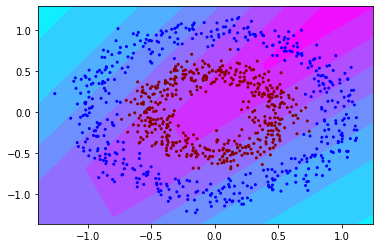

In [78]:
plot_class_model(X_val, y_val, model)

- Tramite le variabili nascoste non lineari, il modello è riuscito a individuare una suddivisione delle classi composta da più iperpiani

- Possiamo visualizzare i dati nello spazio delle due variabili nascoste
- Dal validation set `X_val` ricaviamo i corrispondenti valori `H_val` delle variabili nascoste
  - usiamo pesi e bias del primo strato del modello per calcolare la combinazione lineare degli input, quindi applichiamo la funzione ReLU

In [79]:
H_val = relu(X_val @ model.coefs_[0] + model.intercepts_[0])

- Visualizziamo quindi un grafico a dispersione su queste due variabili, colorando i dati in base alla classe effettiva

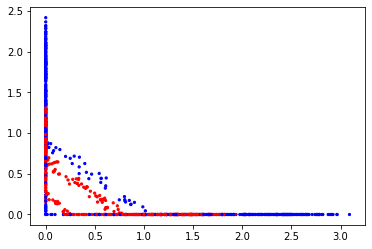

In [80]:
plt.scatter(*H_val.T, s=5, c=np.where(y_val, "red", "blue"));

- Si nota che in questo spazio si può ottenere una separazione lineare migliore (anche se non netta) delle due classi
- Possiamo sovrapporre al grafico l'iperpiano individuato dallo strato di output

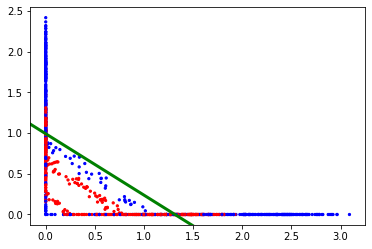

In [81]:
# ricreo lo scatter plot sopra
plt.scatter(*H_val.T, s=5, c=np.where(y_val, "red", "blue"))
xlim, ylim = plt.xlim(), plt.ylim()
# ricavo pesi e bias dell'ultimo strato della rete
w = model.coefs_[1].T[0]
b = model.intercepts_[1]
# estraggo campioni di punti dell'iperpiano e lo disegno
sep_x = np.linspace(*xlim, 2)
sep_y = -w[0]/w[1]*sep_x -b/w[1]
plt.plot(sep_x, sep_y, c="green", lw=3);
plt.xlim(xlim); plt.ylim(ylim);

- Aumentiamo ora il numero di variabili nascoste a 8, per aumentare l'espressività del modello

In [82]:
model = MLPClassifier(hidden_layer_sizes=6, activation="relu", random_state=42)
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [83]:
model.score(X_val, y_val)

0.946

- L'accuratezza è nettamente migliorata

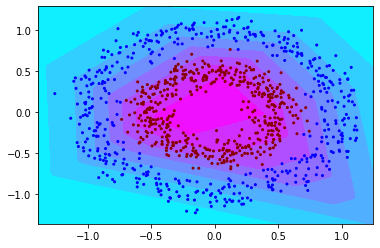

In [84]:
plot_class_model(X_val, y_val, model)

- Dalla combinazione lineare di un numero sufficiente di variabili nascoste, riusciamo ad ottenere un'ottima approssimazione del modello basato su variabili di grado 2 **senza aver definito manualmente alcuna variabile!**

- Il multi-layer perceptron ha molti parametri impostabili oltre a quelli visti
- Tra questi possiamo impostare il numero di _epoche_, ovvero di iterazioni compiute sul training set
  - ad ogni iterazione, la discesa gradiente stocastica processa le osservazioni in gruppi casuali, detti _minibatch_
- Possiamo impostare il numero di epoche col parametro `max_iter`
- Di default è 200, proviamo quì ad alzarlo a 1.000 mantenendo le stesse impostazioni di prima

In [85]:
model = MLPClassifier(hidden_layer_sizes=6, max_iter=1000, activation="relu", random_state=42)
model.fit(X_train, y_train);

- Il tempo per addestrare il modello aumenta, ma anche l'accuratezza

In [86]:
model.score(X_val, y_val)

0.989

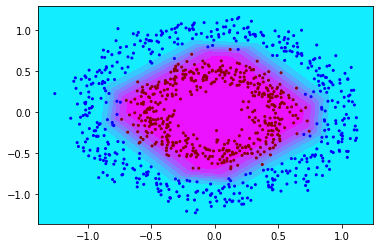

In [87]:
plot_class_model(X_val, y_val, model)

- Aumentando il numero di iterazioni del training set, si può notare che il modello è più preciso e più "sicuro": la distribuzione delle probabilità separa più nettamente i due cerchi

- Possiamo anche variare la _batch size_, ovvero il numero di osservazioni in ogni minibatch durante l'addestramento
- Proviamo ad esempio a mantenere le 200 epoche di default, ma a cambiare la batch size da 200 (default) a 50

In [88]:
model = MLPClassifier(hidden_layer_sizes=6, batch_size=50, activation="relu", random_state=42)
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


- Anche in questo caso il tempo per l'addestramento è aumentato rispetto a prima, in quanto ciascuna epoca richiede più passaggi, ma anche in questo modo l'accuratezza è migliorata

In [89]:
model.score(X_val, y_val)

0.992

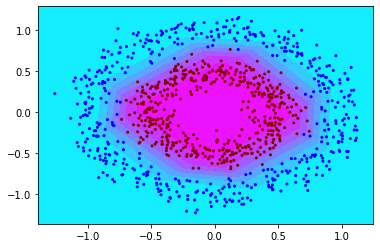

In [90]:
plot_class_model(X_val, y_val, model)

- Nei modelli sopra abbiamo considerato un unico strato di variabili nascoste
- Possiamo però introdurre un numero arbitrario di questi strati, in modo tale che l'input di ciascuno sia l'output di quello sottostante
- Ciascuno strato può avere un numero diverso di variabili nascoste
  - generalmente il numero di variabili si riduce man mano che ci si avvicina all'output finale della rete
  - l'idea è che le variabili negli **strati superiori** (più vicini all'output della rete) rappresentino **informazioni di più alto livello** rispetto a quelli sottostanti

- Consideriamo ad esempio un modello dove
  - un primo strato di 4 variabili nascoste è calcolato dalle variabili in input
  - da queste viene calcolato un secondo strato di 2 variabili nascoste
  - da queste viene calcolato l'output finale
- Creiamo un `MLPClassifier` indicando in `hidden_layer_sizes` una tupla con i numeri di variabili in ciascuno strato, in questo caso 4 e 2

In [91]:
model = MLPClassifier(hidden_layer_sizes=(4, 2), activation="relu", random_state=346346)
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [92]:
model.score(X_val, y_val)

0.903

- Questa volta abbiamo tre gruppi di pesi e bias: quelli del primo strato nascosto, quelli del secondo e quelli per l'output

In [93]:
model.coefs_

[array([[-0.39325268, -1.97450343,  0.29704215,  1.0615451 ],
        [-1.35165159, -1.10714854, -1.08765132, -1.37464659]]),
 array([[ 0.68017556,  0.30916924],
        [-1.12797845,  0.19131857],
        [ 1.04889929,  0.03509317],
        [-2.09441281,  1.48976843]]),
 array([[ 1.31517725],
        [-0.97719811]])]

In [94]:
model.intercepts_

[array([ 1.2544295 , -0.11637562,  1.11916832, -0.33474098]),
 array([ 0.27230613, -0.42928501]),
 array([-0.96960548])]

- Con l'aggiunta di molteplici strati si possono creare suddivisioni più complesse dello spazio

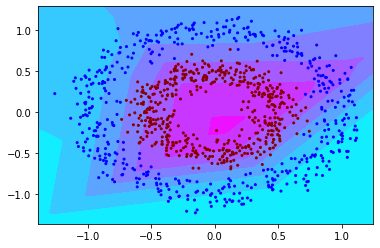

In [95]:
plot_class_model(X_val, y_val, model)

## Esercizio 4: Visualizzazione delle variabili nascoste

- Visualizzare in un grafico a dispersione la distribuzione dei dati del validation set nello spazio individuato dal secondo strato nascosto del modello, sovrapponendo l'iperpiano di separazione individuato dallo strato di output
  - adattare il codice utilizzato sopra per calcolare e visualizzare le variabili nascoste nella rete con un singolo strato nascosto

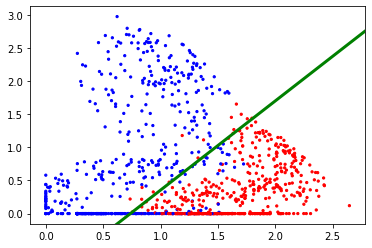

In [97]:
# dalle variabili di input calcoliamo quelle del primo strato nascosto
H1_val = relu(X_val @ model.coefs_[0] + model.intercepts_[0])

# da queste calcoliamo quelle del secondo strato nascosto
H2_val = relu(H1_val @ model.coefs_[1] + model.intercepts_[1])

# generiamo il grafico, adattando il codice usato sopra
plt.scatter(*H2_val.T, s=5, c=np.where(y_val, "red", "blue"))
xlim, ylim = plt.xlim(), plt.ylim()
w = model.coefs_[2].T[0]
b = model.intercepts_[2]
sep_x = np.linspace(*xlim, 2)
sep_y = -w[0]/w[1]*sep_x -b/w[1]
plt.plot(sep_x, sep_y, c="green", lw=3);
plt.xlim(xlim); plt.ylim(ylim);

- Il _multi-layer perceptron_ visto quì è un esempio semplice di _rete neurale_, un modello di apprendimento basato sulla combinazione di molteplici nodi
  - ciascun nodo è un semplice modello lineare con applicata una _funzione di attivazione_, es. ReLU
- I modelli per le applicazioni reali più complesse possono arrivare ad avere molti strati (es. una decina) con un numero enorme di nodi complessivi (es. milioni)
- Questi modelli sono alla base del _deep learning_, l'apprendimento basato su **molteplici livelli di astrazione** dei dati **appresi automaticamente** dal modello stesso
  - sono modelli particolarmente appropriati per il processamento di dati **non strutturati**, quali immagini e testi, da cui solitamente è necessario estrarre manualmente molte feature

## Esercizio 5: Modello multi-layer perceptron su caso di studio

- Riprendiamo il dataset del caso di studio sul marketing mirato, suddividendolo in training e test set

In [98]:
X = ctds.drop(columns="target")
y = ctds["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1/3, random_state=42)

- **(5a)** Effettuare una grid search con cross validation a 3 fold stratificati sul training set per individuare i parametri migliori di un classificatore multi-layer perceptron con
  - standardizzazione dei dati in ingresso
  - 3 possibili configurazione degli strati nascosti
    - uno strato di 16 variabili
    - uno strato di 32 variabili
    - due strati di 16 e 8 variabili rispettivamente
  - batch size di 100 oppure 200
- **(5b)** Ottenere la configurazione risultata migliore
- **(5c)** Verificare sul test set l'accuratezza del modello con tale configurazione

In [100]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(activation="relu"))
])
grid = {
    "mlp__hidden_layer_sizes": [16, 32, (16, 8)],
    "mlp__batch_size": [100, 200]
}
skf = StratifiedKFold(3, shuffle=True)
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

In [101]:
gs.best_params_

{'mlp__batch_size': 100, 'mlp__hidden_layer_sizes': 16}

In [102]:
gs.score(X_test, y_test)

0.5681921159945628